# Malaria Project

## Introduction 
### Members
#### Student 1
Name: Sebastian Schwarz
<br>Group : intermediate
#### Student 2
Name : Youssef Hantous
<br>Group : intermediate


### Data name :
**A geo-coded inventory of anophelines in the Afrotropical Region south of the Sahara: 1898-2016**

### Data URL : 
- Kaggle: https://www.kaggle.com/jboysen/malaria-mosquito 
- Dataverse: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/NQ6CUN
<br>The paper describing how this dataset was compiled can be found here: https://wellcomeopenresearch.org/articles/2-57/v1 

##### Project Description
The aim of this project is to study the distribution and evolution of anophenile vectors of Malaria in Africa. 
The dataset is a compilation of all available Subsaharian mosquito studies from 1898 to 2016. It was compiled in *Kyalo D, Amratia P, Mundia CW et al. A geo-coded inventory of anophelines in the Afrotropical Region south of the Sahara: 1898-2016*, published in 2017 with the help of the KEMRI-Wellcome Trust, and in collaboration with many major research agencies on Malaria. 

This data should help better understand how malaria developped in the past century and what species are primarily associated with its expansion. 

We want to present this data in a clear fashion, showing trends in the evolution and the spread of anopheniles in Africa, and try to predict the future repartition of main malaria transmitting species. 

##### Github Repository
- https://github.com/SebastianS09/Malaria (peut être pas) 

*Please note: internet connection is required for proper execution. Interactive Plotly graphs will not be displayed correctly in Safari, latest version (5.2) of Jupyter Notebook is required (http://jupyter-notebook.readthedocs.io/en/stable/changelog.html) *

## Code
#### Data Import auditing and cleaning

In [ ]:
import numpy as np 
import pandas as pd 

## The data was uploded on github to easily download it from any python session. 
data_raw = pd.read_csv("https://raw.githubusercontent.com/SebastianS09/Malaria/master/Data/Malaria.csv")

print("The dataset has ",data_raw.shape[0],"rows and ",data_raw.shape[1],"columns")

data_raw.head(10)


One observation of the data set is associated with one location, time and a source study. I consists of saying wehter a species / subspecies of mosquito was detected during a particular survey or not.

The **location information** is displayed as follows: 
- Country and Village name
- GAUL administrative regions (https://en.wikipedia.org/wiki/Global_Administrative_Unit_Layers) which are a unified spatial admnistrative unit system
- Geospatial coordinates and source

The **historical information** is displayed as follows: 
- Each survey has a start and an end date. We will audit this in the next cell

There is **supplementary information** (meta-data on the study) on the survey namely:
- Adults/Larvae: whether the survey was conducts on adults or larvae (live in water), sometimes unknown
- Sampling methods: how the speciemens where caught 
- Identification methods: how they were attributed to one species
- Other names and other species: if the species found also have other names and if they were other species present than the main 36 quoted
Details of the abreviations can be found here: https://github.com/SebastianS09/Malaria/blob/master/Data/Africa%20Vectors%20database_1898-2016_key.pdf

Finally, there is the **source study** from which the information was taken.

We will explore this supplementary information later

In [ ]:
import matplotlib.pyplot as plt
#increasing size of graphs
plt.rcParams['figure.dpi'] = 72*2

dates = np.vstack([data_raw["YeStart"],data_raw["YeEnd"]]).T
plt.hist(dates,bins=50, alpha=0.75, label=['Start', 'End'])
plt.legend(loc='upper right')
plt.title("Histogram of survey Start and End year")
plt.show()

As we can see, most of the surveys have been executed around the 60s and in the late 2000s. 

However, the start year and the end year do not always coincide, meaning that the surveys may have been run on periods extending one year. Let us look into this with more detail. 

In [ ]:
length = dates[:,1]-dates[:,0]
plt.hist(length, bins=50, facecolor="blue", alpha=0.75)
plt.title("Histogram of Survey length")
plt.show()

Most of the surveys have lasted for less than five years which seems reasonable. 
The fact that there is a non zero number of surveys lasting more than 20 years however is surprising. 
Let us look at this data and query the unique study titles associated to these long period surveys

In [ ]:
long_survey = data_raw[["YeStart","YeEnd","Source_Title"]].query("YeEnd-YeStart>20")
pd.DataFrame(long_survey)

In [ ]:
pd.DataFrame(long_survey["Source_Title"].value_counts().sort_values(ascending = False))

Looking at this summary data, it seems that republication dates have sometimes be taken into account as end dates (see Hamon J studies for example). 

**Moving forward, we will therefore use the start date as the reference date.** We would suggest auditing these long period cases for the sake of the datasets integrity, even if it does not affect us very much here.

Let us move forward and clean the data to only keep the columns we need in our anlaysis. 

##### Removing unecessary geographical precision and study information

The Study_source column is particularly heavy (the description texts are very long). We will remove it to speed up data manipulation processes and ligthen memory usage. 

We will also remove too granular geographical information (Gaul_Admin2 and Full_name which is the name of the village)

We also remove spaces, dots and slashes from the column names to avoid errors when manipulating data. 

In [ ]:
print(data_raw.memory_usage(deep=True))

#harmonizing column names to avoid errors
data_raw.columns = [i.replace(' ', '_') for i in data_raw.columns]
data_raw.columns = [i.replace('.', '_') for i in data_raw.columns]
data_raw.columns = [i.replace('/', '_') for i in data_raw.columns]
col_rm = ['GAUL_Admin2','Full_Name','LatLong_Source','Source_Title']

#create a dataframe with dropped columns
data_rm = data_raw.drop(col_rm, axis=1)



##### Cleaning Adults/Larvae field for Case

We notice that we have an occurence of Adults/larvae with a minuscule which we want to clean

In [ ]:
print("Initial data: \n",data_raw["Adults_Larvae"].value_counts(),"\n")

data_raw["Adults_Larvae"] = data_raw["Adults_Larvae"].replace("Adults, larvae","Adults, Larvae")

print("Cleaned data: \n",data_raw["Adults_Larvae"].value_counts())

##### Replacing Y and NaN with 0 and 1 for ease of understanding (col 7 to 33)
As we can see, the presence of an anophenile is encoded in columns holding the species' names, with "Yes" if it is present and "NaN" otherwise. 
We will replace these values to 0 and 1 to be able to perform mathematical operations on the columns

In [ ]:
print("Column titles: \n",list(data_raw),"\n")

#making a copy of the data with dropped columns
data_clean = data_rm.copy()

#list of columns with mosquito information
ano = list(data_clean)[6:32]

print(data_clean[ano[:3]].head(2))

#Let us replace Y and NaN
data_clean[ano] = data_clean[ano].replace(['Y'],1)
data_clean[ano] = data_clean[ano].fillna(0)

#inspection
data_clean.head(10)

In [ ]:
#Print basic statistics on the new cleaned data set 

data_clean.describe(include="all")

##### Editing Other Species
We see that we have other species not mentionned in the column names in the last column. Let us check if they are relevant (in terms of frequency vs. species with dedicated columns):

In [ ]:
#splitting the last column as the additional species are comma separated
other_f = data_clean['Other_Anopheline_species'].str.split(', ', expand=True)
other_f.fillna(0,inplace=True)

#counting the occurence in each new column
a = other_f[0].value_counts().to_frame()

print(a.head(10))

#removing the count of 0
for i in list(other_f.drop(0,axis=1)):
    a = a.join(other_f[i].value_counts().to_frame())
a.fillna(0,inplace=True)

#summing the columns up to have a definite count
pd.DataFrame(a.sum(axis=1).sort_values(ascending = False)[1:,])

Let us compare this to the occurences of mosquitos that have dedicated column names

In [ ]:
pd.DataFrame(data_clean[ano].sum(axis=0).sort_values(ascending = False))

As we can see, there are quite high occuring species in "Others". they would rank above An Mouscheti in the primary vector classification. 

However, and as stated in the abstract, the classification has not be done exclusively on occurence. According to the authors of the dataset, *"The definition of secondary vectors is complex and often site/time specific"* We refer to the paper for further information but the main point is that secondary vectors do not transmit paludism to humans, or in very rare cases. 

For the sake of the exercise and reflecting information of this databse of anopheniles: http://bioinfo-web.mpl.ird.fr/identiciels/anopheles/html/taxa/pretoriensis_A_.html, we will add  An Pretoriensis to the primary vectors as they have been transmitting fever generating arboviruses in Nigeria

In [ ]:
An_pretoriensis = data_clean["Other_Anopheline_species"].str.contains("An pretoriensis").fillna(0)*1
data_clean.insert(32,"An_pretoriensis",An_pretoriensis)

#### MetaData analysis
Let us explore the metadata associated to the records which is:
- Adults/Larvae
- Sampling_Methods
- Species_Identification

We will start with some quick summarizing and plotting

##### Species type survey Attributes in time and Space

In [ ]:
#plotting the distributionover time using a pivot table
AL = data_raw[["YeStart","Adults_Larvae"]]
AL_pivot = AL.reset_index().pivot_table(index = "YeStart", columns = "Adults_Larvae",aggfunc=lambda x: len(x.unique())).fillna(0)
AL_pivot.columns = AL_pivot.columns.droplevel()

x = AL_pivot.index.values
y = np.vstack(AL_pivot[i] for i in AL_pivot.columns)
y_norm = (y/y.sum(axis=0))
col_names = list(AL_pivot)

#plotting using pandas buil-in matplot lib implementation
AL_plot = pd.DataFrame(y_norm.T,columns=col_names)
AL_plot.index = x
AL_plot.plot.bar(stacked = True)

#defining additional parameters of the plot
ax = plt.gca() 
ax.set_xticks(range(2,120,10))
ax.set_xticklabels(range(1900,2020,10))

plt.legend(loc='upper left',ncol=4, mode="expand")
plt.title("Bar Chart of survey type")
plt.ylim(ymax = 1.2, ymin = 0)
plt.show()

It appears that over time, surveys focused in particular on Adults but also Larvae are prefered over mixed surveys. This makes sense as it must be easier to distinguish species and to make more accurate surveys. 
Also, Unknown surveys tend to diminish over time, due to better reporting

Let us check if there is a geographical influence:

In [ ]:
#function to calculate breaks in a sorted dataframe, which we will use to create subsets to map 

def get_lim(df,col):
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input is not a pandas DataFrame")
    if not col in list(df):
        raise ValueError("Column name is not in the selected dataframe")
    val=df[col].unique()
    temp = []
    temp_s = [0]
    out = []
    for i in range(0,len(val)):
        temp.append(len(df[df[col]==val[i]]))
    for i in range(0,len(val)):
        temp_s.append(sum(temp[0:i+1]))
    for i in range(0,len(val)):
        out.append((temp_s[i],temp_s[i+1]))
    return(out)    

#function to generate colormaps
#source: https://stackoverflow.com/questions/876853/generating-color-ranges-in-python
import colorsys

def get_N_HexCol(N=5):
    HSV_tuples = [(x * 1.0 / N, 0.9, 0.9) for x in range(N)]
    hex_out = []
    for rgb in HSV_tuples:
        rgb = map(lambda x: int(x * 255), colorsys.hsv_to_rgb(*rgb))
        hex_out.append('#%02x%02x%02x' % tuple(rgb))
    return hex_out

We will use Plotly to generate nice interactive Maps. 

Map tools such as Basemap or folium offer either less quality in interaction with a Jupyter notebook or a not so friendly user experience.

Plotly is an open source collaborative tool for generating plots in different languages, with a quite transparent implementation. 

Documentation can be found here: https://plot.ly/python/

There is a hosted version which needs an account and an API key, but we will be using the offline tool (which explains the size of the notebook)

The concept is to define a dictionnary with data (defining the coordinates and the caracteristics of the points) and a dictionnary with a layout (defining the appearance of the map). Interactivity is built in, and other features such as sliders and buttons can be added (example beneath). 

In [ ]:
import plotly as py
from plotly import tools

#needed to plot offline in the notebook
py.offline.init_notebook_mode(connected=True)

#selection of the Adults_larvae column and sorting.
#We will plot surveys since the 80s only to limit the size of the maps

AL_G = data_raw[data_raw["YeStart"]>1980][["Adults_Larvae","Lat","Long"]]
AL_G = AL_G.sort_values(["Adults_Larvae"])

#defining the limits and the color map
limits = get_lim(AL_G,"Adults_Larvae")
colors = get_N_HexCol(len(limits))
data = []
names=col_names

for i in range(len(limits)):
    lim = limits[i]
    df_sub = AL_G[lim[0]:lim[1]]
    data.append(dict(
        type = 'scattergeo',
        locationmode = 'africa',
        lon = df_sub['Long'],
        lat = df_sub['Lat'],
        marker = dict(
            color = colors[i],
            line = dict(width=0.5, color='rgb(40,40,40)'),
            sizemode = 'area'
        ),
        name=names[i])
               )

layout = dict(
        title = 'Survey anophenile subject type after 1980',
        showlegend = True,
        hovermode = False,
        geo = dict(
            scope='africa',
            projection=dict( type='africa' ),
            showland = True,
            landcolor = 'rgb(185, 185, 185)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(200, 200, 200)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )

fig = dict(data=data, layout=layout)
py.offline.iplot(fig)

From a Geographical perspective, there appears to be no particular preference of survey type since the eighties. 
However, very few surveys have been conducted in central Africa
Plotting before the sixties show that most Central Africa surveys have been conducted before the sixties, with an Unknown methodology concerning subjects. 

In [ ]:
AL_G = data_raw[data_raw["YeStart"]<1960][["Adults_Larvae","Lat","Long"]]
AL_G = AL_G.sort_values(["Adults_Larvae"])

#defining the limits and the color map
limits = get_lim(AL_G,"Adults_Larvae")
colors = get_N_HexCol(len(limits))
data = []

for i in range(len(limits)):
    lim = limits[i]
    df_sub = AL_G[lim[0]:lim[1]]
    data.append(dict(
        type = 'scattergeo',
        locationmode = 'africa',
        lon = df_sub['Long'],
        lat = df_sub['Lat'],
        marker = dict(
            color = colors[i],
            line = dict(width=0.5, color='rgb(40,40,40)'),
            sizemode = 'area'
        ),
        name=names[i])
               )
layout = dict(
        title = 'Survey anophenile subject type before 1960',
        showlegend = True,
        hovermode = False,
        geo = dict(
            scope='africa',
            projection=dict( type='africa' ),
            showland = True,
            landcolor = 'rgb(185, 185, 185)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(200, 200, 200)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )

fig = dict(data=data, layout=layout)
py.offline.iplot(fig)   

##### Sampling Methods

Let us now analysis the sampling methods that have been used
We will first compute the top 10 sampling methods

Here the abreviations as a reminder:

<table class="tableizer-table">
<thead><tr class="tableizer-firstrow"><th>Abreviation</th><th>Description</th></tr></thead><tbody>
 <tr><td>ABC</td><td>Animal Bait Catches</td></tr>
 <tr><td>Bednet traps</td><td>Bed net traps</td></tr>
 <tr><td>CDC Light traps</td><td>CDC light traps</td></tr>
 <tr><td>HBC/NBC</td><td>Human/Night Bait Catches (may be witnin a double sided net)</td></tr>
 <tr><td>HLC</td><td>Human Landing Catches </td></tr>
 <tr><td>NBC</td><td>Night Bait Catches</td></tr>
 <tr><td>IR</td><td>Indoor resting (Often written as room searches, aspirators or hand catches indoors)</td></tr>
 <tr><td>OS</td><td>Outdoor sampling</td></tr>
 <tr><td>LC</td><td>Larval Collections</td></tr>
 <tr><td>Exit traps</td><td>Exit traps</td></tr>
 <tr><td>PSC </td><td>Pyrethrum Spray Catches</td></tr>
 <tr><td>ITT </td><td>Ifakara Tent Traps</td></tr>
</tbody></table>

In [ ]:
top_methods = pd.DataFrame(pd.Series(' '.join(data_clean['Sampling_Methods']+",").split(", ")).value_counts()[:10], columns = ["Count"])

#let us check the evolution of the top 3 sampling methods over time and of Unknown sampling method (fifth most frequent)

print(top_methods[0:5],"\n")

M0 = data_clean[data_clean['Sampling_Methods'].str.match(top_methods.index[0])]["YeStart"]
M1 = data_clean[data_clean['Sampling_Methods'].str.match(top_methods.index[1])]["YeStart"]
M2 = data_clean[data_clean['Sampling_Methods'].str.match(top_methods.index[2])]["YeStart"]
MU = data_clean[data_clean['Sampling_Methods'].str.match("Unknown")]["YeStart"]

#aggregate data 
M0v = M0.value_counts()
M1v = M1.value_counts()
M2v = M2.value_counts()
MUv = MU.value_counts()

conc = pd.concat([M0v,M1v,M2v,MUv],axis=1)
conc.columns=[top_methods.index[[0,1,2,4]]]
conc.plot.bar(stacked=True)

ax = plt.gca() 
ax.set_xticks(range(2,120,10))
ax.set_xticklabels(range(1900,2020,10))
plt.title("Bar Chart of collection method")
plt.ylim(ymax = 300, ymin = 0)
plt.show()

We observe a diminution of "Unknown" methods over time, again due to better accountability of recent studies. 

Larval collection is on the rise in the 2000s, after having been used in the 50s and the 60s
In-house capture seems to be the more and more used (makes sense as the propagation of malaria is mainly due to anopheniles that attack humans inside their houses)

However, there is a prevalence of mixed methods: 

In [ ]:
multiple_occ = pd.DataFrame([data_clean["Sampling_Methods"],data_clean["Sampling_Methods"].str.count(", ")+1]).T

multiple_occ.columns = ["Sampling_Methods","Number of Methods"]
multiple_occ.groupby(["Number of Methods"]).count().plot.bar()
plt.title("Number of sampling methods used per survey")
plt.show()



As we can see, more than half the surveys are using at least two methods. Let us check if there is a historical trend in the numbers of methods used: 

In [ ]:
mean_sample = pd.DataFrame([data_clean["YeStart"],np.array([1]*len(data_clean["YeStart"])),np.array([1]*len(data_clean["YeStart"])),data_clean["Sampling_Methods"].str.count(", ")+1]).T

#adding a datetime index to use rolling from pandas
mean_sample.columns = ["year","month","day","count"]
mean_sample["date"] = pd.to_datetime(mean_sample[["year","month","day"]])
mean_sample = mean_sample.drop(["year","month","day"],axis=1)

#comuting rolling avergages
m0 = mean_sample.groupby("date").mean().rolling(window = 1).mean()
m5 = mean_sample.groupby("date").mean().rolling(window = 5).mean()
m20 = mean_sample.groupby("date").mean().rolling(window = 20).mean()

out = pd.concat([m0,m5,m20],axis=1)
out.columns = ["1y MA","5Y MA","20Y MA"]
out.plot()
plt.title("Mean number of sampling methods over time")
plt.show()

We see some irregularities at year level. 

Smoothing them out using moving averages, we can see that the number of sampling methods used in a single survey was high at the beginning of the century, decreased between world wars, increased again in the sixties and is decreasing ever since 

##### Focus on species indentification

Let us see now how species have been identified. As a reminder, the list of abreviations: 

<table class="tableizer-table">
<thead><tr class="tableizer-firstrow"><th>Species ID method</th><th>Description</th></tr></thead><tbody>
 <tr><td>CBS</td><td>Chromosone Banding </td></tr>
 <tr><td>DNA</td><td>Sequencing DNA probes</td></tr>
 <tr><td>M </td><td>Morphology</td></tr>
 <tr><td>PCR</td><td>Polymerase Chain Reaction</td></tr>
</tbody></table>

We have only four methods, but a combination of methods can be used: 

In [ ]:
multiple_id = pd.DataFrame([data_clean["Species_Identification"],data_clean["Species_Identification"].str.count(", ")+1]).T

multiple_id.columns = ["Species_Identification","Number of Methods"]
multiple_id.groupby(["Number of Methods"]).count().plot.bar()
plt.title("Number of identification methods used per survey")
plt.show()

Again, roughly half the surveys have at least two id methods. 

Does this change over time ?

In [ ]:
mean_id = pd.DataFrame([data_clean["YeStart"],data_clean["Species_Identification"].str.count(", ")+1]).T
mean_id.columns = ["YeStart","Number of Methods"]
mean_id.groupby(["YeStart"])["Number of Methods"].mean().plot()
plt.title("Mean number of identification methods over time")
plt.show()


We see a slight positive trend from 1 to 2 identification methods between 1960 and 2000. Between 1900 and 1930, there is quite a high volatility in the number of methods used. The value in 1918 is surprising as DNA sequencing was not available at this point (starts in the 80s as we can see on the graph)

**Further inspection on these surprising data points**

In [ ]:
early_dna  = pd.DataFrame([data_clean["YeStart"],data_clean["Species_Identification"],data_clean["Species_Identification"].str.count(", ")+1,data_raw["Source_Title"]]).T
early_dna.columns= ["YeStart","Species_Identification","Count","Source_Title"]
early_dna[(early_dna["Species_Identification"].str.contains("DNA")) & (early_dna["YeStart"]<1950)].sort_values("YeStart")


There appears to be a limited number of studies mentionning DNA as a source before the 50s. 
This would be worth having a look into, and determining what exactly was ment. 

Here is the list of the studies: 

In [ ]:
values_early_dna = early_dna[(early_dna["Species_Identification"].str.contains("DNA")) & (early_dna["YeStart"]<1940)].sort_values("YeStart")

values_early_dna["Source_Title"].str.slice(0,50).value_counts()

These studies would be worth looking into, in particular Kumm HW and Symes CB as they account for 16 of the occurences. 

Let us check now what method is the prefered method when only one is chosen:

In [ ]:
single_id = pd.DataFrame([data_clean["Species_Identification"],data_clean["Species_Identification"].str.count(", ")+1]).T
single_id.columns = ["Species_Identification","Number of Methods"]
single_id_out = single_id[single_id["Number of Methods"] == 1]
single_id_out.groupby(["Species_Identification"]).sum()


Every time a single method has been used (roughly 50% of studies), it was a morphological analysis. 

As such, it is confirmed that other methods come on top to validate this morphological approach. 

Let us check the percent of single morphological studies over time: 

In [ ]:
single_id = pd.DataFrame([data_clean["YeStart"],data_clean["Species_Identification"],data_clean["Species_Identification"].str.count(", ")+1]).T
single_id.columns = ["YeStart","Species_Identification","Number of Methods"]
single_id_out = single_id[single_id["Number of Methods"] == 1]

single_count = single_id_out.groupby(["YeStart"]).sum()["Number of Methods"]
total_count = data_clean["YeStart"].value_counts()

out = pd.concat([single_count,total_count],axis=1)
out.columns = ["single","total"]

out_p = out.single/out.total
out_p.plot()
plt.title("Fraction of single test surveys over time")
plt.show()

The trend is clearly decreasing, indicating that as time goes by, scientist have been more and more using multiple methods to identify anophenile vectore in Africa. 

Let us have a look at the geography of the identification methods, to see, again if there is a preference. 

In [ ]:
M_G = data_raw[data_raw["YeStart"]>1960][["Species_Identification","Lat","Long"]]

M_G = M_G.sort_values(["Species_Identification"])
M_G_s = M_G.copy()
M_G_s.Species_Identification = M_G.Species_Identification.str.strip("M, ")

M_G_s = pd.concat([M_G_s,M_G_s.Species_Identification.str.count(", ")+1],axis=1)

M_G_s.columns = ["Id","Lat","Long","Count"]
M_G_s.Id.replace("","M",inplace=True)

M_G_plot = M_G_s[M_G_s["Count"]<2][["Id","Lat","Long"]]
M_G_plot = M_G_plot.sort_values(["Id"])
M_G_plot = M_G_plot[M_G_plot.Id.isin(M_G_plot.Id.value_counts().index[M_G_plot.Id.value_counts()>10].values)]


limits = get_lim(M_G_plot,"Id")
colors = get_N_HexCol(len(limits))
data = []
names= M_G_plot.Id.value_counts().index[M_G_plot.Id.value_counts()>10].values

for i in range(len(limits)):
    lim = limits[i]
    df_sub = AL_G[lim[0]:lim[1]]
    data.append(dict(
        type = 'scattergeo',
        locationmode = 'africa',
        lon = df_sub['Long'],
        lat = df_sub['Lat'],
        marker = dict(
            color = colors[i],
            line = dict(width=0.5, color='rgb(40,40,40)'),
            sizemode = 'area'
        ),
        name=names[i]))
    
layout = dict(
        title = 'Identification methods of anophenile vectors after 1960',
        showlegend = True,
        hovermode = False,
        geo = dict(
            scope='africa',
            projection=dict( type='africa' ),
            showland = True,
            landcolor = 'rgb(185, 185, 185)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(200, 200, 200)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )

fig = dict( data=data, layout=layout )
py.offline.iplot(fig)


This is quite interesting as it appears some methods have been used very locally, such as the XXX method. 
Other methods seem to be in use all over Africa with a small number of marginal methods (less than 10 occurences). 

#### Mosquito survey repartition by species: historical and geographical analysis

Here follows a geographical analysis of mosquito species repartition over time

##### Evolution of a particular species over time

In [ ]:
mosquitos = ["An_gambiae_complex","An_paludis_","An_coustani_s_l","An_squamous","An_arabiensis","An_funestus__s_l"]
lim_dates=[1898,1930,1970,2016]
data_test = []
y_colours = ["yellow","blue","red"]

layout = dict(
    title = 'African Mosquitos surveys over time and species',
    autosize = False,
    hovermode = False,
    width = 1000,
    height = 900,
    font=dict(family='Arial', size=9),
    )

layout["geo"] = dict(
        scope='africa',
        showland = True,
        landcolor = 'rgb(217, 217, 217)',
        subunitwidth=1,
        countrywidth=1,
        subunitcolor="rgb(255, 255, 255)",
        countrycolor="rgb(255, 255, 255)",
        domain = dict( x = [], y = []))

for i in range(len(mosquitos)):
    for j in range(0,3):
        geo_key = 'geo'+str(i+1)+str(j+1)
        df = data_clean.query(str(lim_dates[j])+'<= YeStart <='+str(lim_dates[j+1]))#+" and Adults_Larvae == 'Adults, Larvae'")
        lons = list(df[df[mosquitos[i]] == 1]['Long'])
        lats = list(df[df[mosquitos[i]] == 1]['Lat'])
    
        data_test.append(
        dict(
            type = 'scattergeo',
            showlegend=False,
            lon = lons,
            lat = lats,
            geo = geo_key,
            marker = dict(
                color = y_colours[j],
                line = dict(width=0.5, color='rgb(155,187,23)'),
                sizemode = 'area'),
            name = 'Presence of'+mosquitos[i]
        )
    )
        ####plot legend
        data_test.append(
        dict(
            type = 'scattergeo',
            showlegend = False,
            lon = [15],
            lat = [30],
            geo = geo_key,
            text = [mosquitos[i]+'<br>'+str(lim_dates[j])+'-'+str(lim_dates[j+1])],
            mode = 'text',
        )
    )
       
        layout[geo_key] = dict(
        scope='africa',
        showland = True,
        landcolor = 'rgb(217, 217, 217)',
        subunitwidth=1,
        countrywidth=1,
        subunitcolor="rgb(255, 255, 255)",
        countrycolor="rgb(255, 255, 255)",
        domain = dict( x = [], y = []),
    )

z = 0
COLS = 3
ROWS = 6
for y in reversed(range(ROWS)):
    for x in range(COLS):
        geo_key = 'geo'+str(ROWS-y)+str(x+1)
        layout[geo_key]['domain']['x'] = [float(x)/float(COLS), float(x+1)/float(COLS)]
        layout[geo_key]['domain']['y'] = [float(y)/float(ROWS), float(y+1)/float(ROWS)]
        z=z+1
        if z > 20:
            break

fig = {'data':data_test, 'layout':layout}

py.offline.iplot(fig, filename='Mosquitos')

In [ ]:

i=0
sl_dates = list(range(1900,2011,10)) + [2016]
colors = get_N_HexCol(len(mosquitos))
data = []

for j in range(len(sl_dates)-1):
    df = data_clean.query(str(sl_dates[j])+'<= YeStart <='+str(sl_dates[j+1]))
    df = df[df[mosquitos[i]] == 1]
    df['text'] = df['Country'] + '<br>Year ' + (df['YeStart']).astype(str)    
    
    data.append(dict(
        type = 'scattergeo',
        visible = False,
        locationmode = 'africa',
        lon = df['Long'],
        lat = df['Lat'],
        text = df['text'],
        geo = 'geo',
        marker = dict(
            color = colors[i],
            line = dict(width=0.5, color='rgb(155,187,23)'),
            sizemode = 'area'
            ),
        name = 'Presence of '+mosquitos[i]+' '+str(sl_dates[j])+'-'+str(sl_dates[j+1])))    
steps = []
for k in range(len(data)):
    step = dict(
        method = 'restyle',
        args = ['visible', [False] * len(data)],
    )
    step['args'][1][k] = True # Toggle i'th trace to "visible"
    steps.append(step)
    
sliders = [dict(
    active = 0,
    currentvalue = {"prefix": "Period: "},
    pad = {"t": len(sl_dates)-1},
    steps = steps
)]

layout = dict(
        title = mosquitos[i]+' presence in surveys over time',
        showlegend = True,
        xaxis = dict(fixedrange=True),
        geo = dict(
            scope='africa',
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
        sliders=sliders
    )

fig = dict(data=data, layout=layout)
py.offline.iplot(fig, filename='Slider')


Now that we observed the mosquito species repartition over Africa, let us now compare it to 
the distribution of Anopheline vectors across the African continent.

In [ ]:
data_clean['text'] = data_clean['Country'] + '<br>Year ' + (data_clean['YeStart']).astype(str)  #Text written on the interactive map
limits = [(1,len(data_clean))]            # We take all the dataset as values considered
colors = ["rgb(155,187,23)"]      # Green color (see "rgb color picker" on Google)


#Now that we decided which points are we going to study, we now decide how to plot them, with
#the function 'dict'. We comment all its components.
Cases_Malaria = dict(                   
    type = 'scattergeo',
    locationmode = 'africa',      # We choose Africa, so that we have the African continent plotted
    lon = data_clean['Long'],             
    lat = data_clean['Lat'],              #lon and lat are the coordinates of the points
    text = data_clean['text'],            #text written when we select a point
    marker = dict(
        color = colors,
        line = dict(width=0.5, color='rgb(155,187,23)'),
        sizemode = 'area'
    ),
    name = 'Presence of Anopheline vectors') #legend

#Now, we are going to decide how to lay out our graph, still with function "dict".
    
graph = dict( 
        title = 'Geographical Distribution of Anopheline Vectors in Africa',     #Title of the graph
        showlegend = True,
        geo = dict(
            scope='africa',
            showland = True,
            landcolor = 'rgb(217, 217, 217)',                       #Color of the continent (light grey)
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"                      #Color of the frontiers (white)
        ),
    )

firstgraph = dict( data=[Cases_Malaria], layout=graph )
py.offline.iplot( firstgraph, validate=False, filename='Presence of Anopheline in Africa' )  #Plot with plotly

Let us now plot a graph describing the presence of Anopheline vectors across the decades in Africa :

In [ ]:
year_dat = data_raw[["YeStart"]]                 #We get rid of all useless columns in this case
year_dat = year_dat.sort_values(["YeStart"])     #We sort the dataset
a=get_lim(year_dat,"YeStart")                    #We get all "limits", that we will use 3 lines below   

df = pd.read_csv('https://raw.githubusercontent.com/SebastianS09/Malaria/master/Data/Malaria.csv')
df=df.sort_values(['YeStart'])

df['text'] = df['Country'] + '<br>Year ' + (df['YeStart']).astype(str)

a10=a[12][1]     #a[x][y] is equal to : 
a11=a10+1        #                     - If y=1 : a[x][1] gives the last index for the value x in the dataset
a30=a[32][1]
a31=a30+1        #                     - If y=0 : a[x][0] gives the first index for the values x
a50=a[52][1]
a51=a50+1
a70=a[72][1]     # For example, for 1910, since it is our 12th year of the dataset (starts at 1898)
a71=a70+1        # we write a[12] to find the first and final index for the year 1910.
a90=a[92][1]
a91=a90+1
a216=len(df)

#Now, let's put "limits" for each two-decades. Each two-decades will be assigned a color in the plot.

limits = [(1,a10),(a11,a30),(a31,a50),(a51,a70),(a71,a90),(a91,a216)]
# limits =[(1898,1910),(1911,1930),(1931,1950),(1951,1970),(1971,1990),(1991,2016)]
colors = ["rgb(0,116,217)","rgb(255,65,54)","rgb(133,20,75)","rgb(255,133,27)","rgb(110,133,58)","rgb(45,187,23)","lightgrey"]
all_cases_ever = []
names=['1890-1910','1911-1930','1931-1950','1951-1970','1971-1990','1991-2016'] 


In [ ]:

for i in range(len(limits)):
    lim = limits[i]
    df_sub = df[lim[0]:lim[1]]
    mal_case = dict(
        type = 'scattergeo',
        locationmode = 'africa',
        lon = df_sub['Long'],
        lat = df_sub['Lat'],
        text = df_sub['text'],
        marker = dict(
            color = colors[i],
            line = dict(width=0.5, color='rgb(40,40,40)'),
            sizemode = 'area'
        ),
        
        name=names[i] )

        
    all_cases_ever.append(mal_case)
    
    
graph2 = dict(
        title = 'Distribution of anopheline vectors across decades',
        showlegend = True,
        geo = dict(
            scope='africa',
            projection=dict( type='africa' ),
            showland = True,
            landcolor = 'rgb(185, 185, 185)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(200, 200, 200)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )

secondgraph = dict( data=all_cases_ever, layout=graph2 )
py.offline.iplot( secondgraph, validate=False, filename='Presence_anopheline_accross_decades' )

#### Data inspection tools

As a second step we will write some tools (functions), that will allow us to inspect parts of the data, in particular to extract records of the dataset and to present them in a new and interesting fashion

- function to get all the mosquitos associated to a country and a time frame
- function to get all the records near a given point of interest 
- function to XXX

In [ ]:
from geopy.geocoders import Nominatim

def get_coord(x):
    if not isinstance(x,str):
         raise ValueError("Not a String")
    geolocator = Nominatim()
    if geolocator.geocode(x) == None:
        raise ValueError("Input not recognized")
    location = geolocator.geocode(x)
    return((location.latitude, location.longitude))

def geo_africa_check(coord):
    lat = coord[0]
    long = coord[1]
    return -36 < lat < 36 , -26 < long < 54
    
#https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
#formula to calculate distance between two points (km)

def haversine(lat1, lon1, lat2, lon2):
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return np.multiply(c,r)


In [ ]:
import warnings

def true_mosquito(mosquito,df=data_clean):
    val= 'FALSE'
    for i in df.columns:
        if mosquito==i:
            val='TRUE'
        
    return val
                

def list_countries(df=data_clean):
    return np.unique(df['Country'])


def observations_near(x,km=500):    
    #coordinates exist :
    try:
        if geo_africa_check(get_coord(x)) != (True,True):
            warnings.warn("Specified place out of range: not in target African zone!")
    except:
        raise ValueError("Entered place does not exist, check spelling / existence")
    #check distance
    if not (isinstance(km,int) or isinstance(km,float)):
        raise ValueError("Please enter distance as integer or float")

    #create arrays of coordinated of point of interst 
    p_lat = np.array([get_coord(x)[0]]*len(data_clean["Lat"]))
    p_lon = np.array([get_coord(x)[1]]*len(data_clean["Long"]))
    
    #compute distance and return points with distance less than specified km
    return(data_clean[(haversine(p_lat,p_lon,data_clean["Lat"],data_clean["Long"])<km)])



In [ ]:
def plot_observations_near(x,km=500,segmentation="None"):
    try: 
        inp=observations_near(x,km)
    except: 
        raise ValueError("Check Inputs")
    if segmentation not in list(inp)+["None"]:
        raise ValueError("desired segmentation not available, please choose from: "+str(list(df)))
    if inp.empty:
        raise ValueError("No data in requested zone")
    if segmentation == "None":
        limits = [(0,len(inp["Lat"]))]
        names = ["All records"]
    else:
        inp = inp.sort_values(segmentation)
        limits = get_lim(inp,segmentation)
        names = inp[segmentation].value_counts().index

    colors = get_N_HexCol(len(limits))
    data = []
    
    for i in range(len(limits)):
        lim = limits[i]
        df_sub = inp[lim[0]:lim[1]]
        data.append(dict(
            type = 'scattergeo',
            locationmode = 'africa',
            lon = df_sub['Long'],
            lat = df_sub['Lat'],
            geo = 'geo',
            marker = dict(
                color = colors[i],
                line = dict(width=0.5, color='rgb(40,40,40)'),
                sizemode = 'area'),
            name=names[i])
                   )
    
    layout = dict(
        title = 'Plot of observation less than '+str(km)+' km from '+str(x),
        showlegend = True,
        hovermode = False,
        geo = dict(
            scope='africa',
            projection=dict( type='africa' ),
            showland = True,
            landcolor = 'rgb(185, 185, 185)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(200, 200, 200)",
            countrycolor="rgb(255, 255, 255)"
            ),
        )

    fig = dict( data=data, layout=layout)
    py.offline.iplot(fig)

In [ ]:
plot_observations_near("Nairobi",500,"Country")

#### Prospective analysis: number of malaria studies per country

We will try to estimate the numbers of surveys that will be conducted in a given country.

This data can be usefull when linked to other studies, for example Malaria occurences counts. It may reveal that too many resources are being allocated to one country, when it could be more usefull to allocate these ressources to another country. Indeed, studying the repartition of mosquito species in countries with high malaria counts / prospective malaria counts is more useful, as it may allow to developp tools aimed at that particular local mosquito species. 

First, let us extract the relevant data and plot the evolution of time of the number of surveys per country:

In [ ]:
studies = data_clean[["Country","YeStart","YeEnd"]].groupby(["Country","YeStart"]).count()

#setting the year as the index
studies.reset_index(level=0, inplace=True)

studies.columns = ["Country","Count"]

studies.Count.groupby("YeStart").sum().plot()
plt.title("Number of surveys per year")
plt.show()

#example of a record
studies.loc[[1960]]

#let us check the number of records per country:

print(studies.groupby("Country").count().sort_values("Count",ascending = False).head(20))
studies.groupby("Country").count().sort_values("Count",ascending = False).describe()

As we can see, the number of records is sadly not enough (mean number of records being 28, so that over a period of more than a century you have only 28 years with a record).

This value around 1950 is surprising, for safety we will normalize it:

In [ ]:
studies.loc[1952]
#looks like Madagascar
data_raw[(data_raw["YeStart"] == 1952) & (data_raw["Country"] == "Madagascar")]["Source_Title"].value_counts().head(2)

This study counts for 861 records because it compiles all previous studies of Madagascar insects. 
Let us put this number back to a reasonnable number like 10 (second study with the most surveys)

In [ ]:
studies.loc[studies.Count==937,"Count"] = 10
studies[studies["Country"]=="Madagascar"].loc[1952]["Count"] 


Let us plot this data and then proceed to group countries by a larger index to aggregate data. 

In [ ]:
import plotly as py
py.offline.init_notebook_mode(connected=True)

data = []
ind = studies.index.unique().sort_values()
for i in ind:

    study = studies.loc[[i]]
    
    data.append(dict(
        type = 'choropleth',
        visible = False,
        locations = study['Country'],
        locationmode = 'country names',
        z = study['Count'],
        #text = study['Country'],
        colorscale='Volcano',
        colorbar = dict(
            title = 'Number of surveys per country - '+str(i) + "<br> total surveys:"+str(sum(study['Count'])))
      )
               )

dates = []
for k in range(len(ind)):
    step = dict(
        method = 'restyle',
        args = ['visible', [False] * len(ind)],
        label = str(k+1898)
    )
    step['args'][1][k] = True # Toggle i'th trace to "visible"
    dates.append(step)
    
sliders = [dict(
    active = 0,
    currentvalue = {"prefix": "Date: "},
    pad = {"t": len(ind)},
    steps = dates
)]
                
layout = dict(
        title = 'Evolution of number of surveys in Sub-Saharian Africa',
        showlegend = True,
        hovermode = True,
        geo = dict(
            scope='africa',
            projection=dict( type='africa' ),
            showland = True,
            landcolor = 'rgb(300, 300, 300)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(100, 100, 100)"
            ),
        sliders=sliders,
        )

fig = dict( data=data, layout=layout )
py.offline.iplot(fig)

Let us regroup countries now by using the UN subregion categorization (https://en.wikipedia.org/wiki/United_Nations_geoscheme) 
There wille be 5 groups: 
- Eastern Africa
- Middle Africa
- Northern Africa
- Southern Africa
- Western Africa

We will use this source https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/blob/master/all/all.csv for attributing countries.

In [ ]:
UN_ctr = pd.read_csv("https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv")


def UN_code(ctr):
    
    try:
        out = UN_ctr[UN_ctr.name == ctr]["sub-region"].values[0]
        return(out)

    except: 
        warnings.warn(ctr+" not in list")
        return("not found")

studies.Country.apply(lambda x: UN_code(x))

#let us inspect the warnings and add them manually
new_ctr = pd.DataFrame(columns = UN_ctr.columns)
list =[["Cape Verde","","","","","","Western Africa","",""],\
["Democratic Republic of the Congo","","","","","","Middle Africa","",""],\
["Guinea Bissau","","","","","","Western Africa","",""],\
["Tanzania","","","","","","Eastern Africa","",""],\
["Zanzibar","","","","","","Eastern Africa","",""]]

for i in range(len(list)):
    new_ctr.loc[i] = list[i]
    
UN_ctr = UN_ctr.append(new_ctr)

studies["Region"] = studies.Country.apply(lambda x: UN_code(x))

print(studies.head(20))


In [622]:
##let us aggregate at region level for plotting purposes
plot_region = studies_r.reset_index()
plot_region = plot_region.merge(UN_ctr[["name","sub-region"]], left_on = 'Region', right_on = 'sub-region')[["YeStart","Count","name","Region"]]
plot_region = plot_region.set_index("YeStart")
plot_region

,Count,name,Region
YeStart,,,
1898,2,Benin,Western Africa
1898,2,Burkina Faso,Western Africa
1898,2,Cabo Verde,Western Africa
1898,2,Côte d'Ivoire,Western Africa
1898,2,Gambia,Western Africa
1898,2,Ghana,Western Africa
1898,2,Guinea,Western Africa
1898,2,Guinea-Bissau,Western Africa
1898,2,Liberia,Western Africa


In [ ]:
#let us aggregate at region level for later analysis purposes

studies_r = studies.groupby(["YeStart","Region"]).sum().reset_index(level = 1)
studies_r = studies_r.reset_index()


In [623]:
import plotly as py
py.offline.init_notebook_mode(connected=True)

data = []
ind = plot_region.index.unique().sort_values()
for i in ind:

    study = plot_region.loc[[i]]
    
    data.append(dict(
        type = 'choropleth',
        visible = False,
        locations = study['name'],
        locationmode = 'country names',
        z = study['Count'],
        text = study['Region'],
        colorscale='Volcano',
        colorbar = dict(
            title = 'Number of surveys per country - '+str(i) + "<br> total surveys:"+str(sum(study['Count'])))
      )
               )

dates = []
for k in range(len(ind)):
    step = dict(
        method = 'restyle',
        args = ['visible', [False] * len(ind)],
        label = str(k+1898)
    )
    step['args'][1][k] = True # Toggle i'th trace to "visible"
    dates.append(step)
    
sliders = [dict(
    active = 0,
    currentvalue = {"prefix": "Date: "},
    pad = {"t": len(ind)},
    steps = dates
)]
                
layout = dict(
        title = 'Evolution of number of surveys in African UN Sub regions',
        showlegend = True,
        hovermode = True,
        geo = dict(
            scope='africa',
            projection=dict( type='africa' ),
            showland = True,
            landcolor = 'rgb(300, 300, 300)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(100, 100, 100)"
            ),
        sliders=sliders,
        )

fig = dict( data=data, layout=layout )
py.offline.iplot(fig)

Now, let us design a time-series based approach on this data.

First, convert the dataframe to a timebased index

In [625]:
a = studies_r.index.values.astype("str")
b = np.array(["-01-01"]*len(studies_r.index.values))
date_index = np.core.defchararray.add(a, b)

studies_d = studies_r.copy()
studies_d.index = pd.DatetimeIndex(date_index)

studies_d

,Region,Count
1898-01-01,Western Africa,2
1899-01-01,Western Africa,3
1900-01-01,Eastern Africa,17
1900-01-01,Western Africa,2
1901-01-01,Eastern Africa,7
1901-01-01,Western Africa,16
1902-01-01,Eastern Africa,6
1902-01-01,Middle Africa,27
1902-01-01,Western Africa,9
1903-01-01,Eastern Africa,34


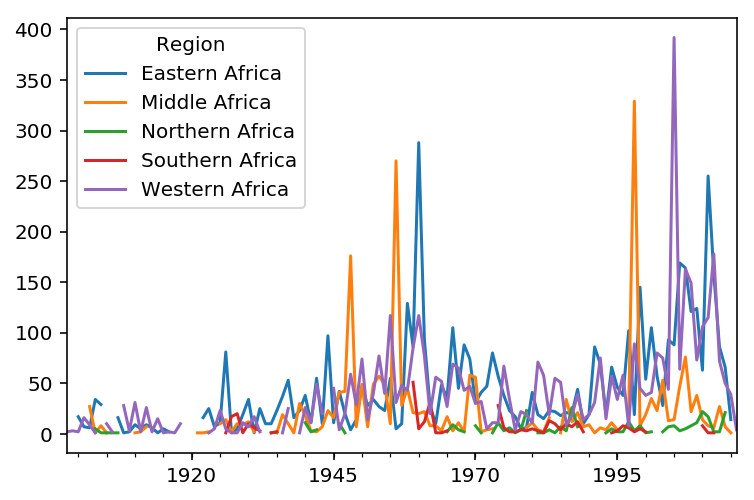

In [626]:
studies_d.pivot(values='Count', columns='Region').plot()


This looks more interesting to study ! 



In [ ]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=5).mean()
    rolstd = timeseries.rolling(window=5).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [ ]:
test_stationarity(studies_d[studies_d.Country == "Angola"].Count)

In [ ]:
studies_d[studies_d.Country == "Angola"].rolling(window=5).mean()